In [1]:
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [4]:
train.head()

,id,Gender,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
0,1,M,0.605,0.470,0.115,1.1140,0.3925,0.2910,0.3100,15
1,2,I,0.430,0.315,0.095,0.3780,0.1750,0.0800,0.1045,8
2,3,I,0.580,0.490,0.195,1.3165,0.5305,0.2540,0.4100,18
3,4,M,0.535,0.405,0.175,1.2705,0.5480,0.3265,0.3370,13
4,5,I,0.310,0.235,0.090,0.1270,0.0480,0.0310,0.0400,6


- id : 샘플 아이디
- Gender : 전복 성별
- Lenght : 전복 길이
- Diameter : 전복 둘레
- Height : 전복 키
- Whole Weight : 전복 전체 무게
- Shucked Weight : 껍질을 제외한 무게
- Viscra Weight : 내장 무게
- Shell Weight : 껍질 무게
- Target : 전복 나이

In [5]:
train.shape

(1253, 10)

In [6]:
# 결측치 확인
def check_missing_col(dataframe):
    missing_col = []
    counted_missing_col = 0
    for i, col in enumerate(dataframe.columns):
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            counted_missing_col += 1
            print (f'결측치가 있는 컬럼은: {col}입니다')
            print (f'해당 컬럼에 총 {missing_values}개의 결측치가 존재합니다')
            missing_col.append([col, dataframe[col].dtype])
        if counted_missing_col == 0:
            print('결측치가 존재하지 않습니다')
        return missing_col

In [7]:
for i, col in enumerate(train.columns):
    print (i, col)

0 id
1 Gender
2 Lenght
3 Diameter
4 Height
5 Whole Weight
6 Shucked Weight
7 Viscra Weight
8 Shell Weight
9 Target


In [8]:
sum(train['id'].isna())

0

In [9]:
missing_col = check_missing_col(train)

결측치가 존재하지 않습니다


In [10]:
train.isnull().sum()

id                0
Gender            0
Lenght            0
Diameter          0
Height            0
Whole Weight      0
Shucked Weight    0
Viscra Weight     0
Shell Weight      0
Target            0
dtype: int64

In [11]:
# id 제거
train = train.drop(columns=['id'],axis=1)

In [12]:
# target 분포 확인
temp = train['Target'].unique()
np.sort(temp) # 오름차순 정렬

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 29])

In [13]:
train.groupby('Target').count().iloc[:,0]

Target
3       5
4      14
5      37
6      88
7     107
8     174
9     200
10    202
11    141
12     79
13     62
14     42
15     26
16     21
17     13
18     12
19      8
20     11
21      5
22      2
23      3
29      1
Name: Gender, dtype: int64

그림 저장: Abalone age by count


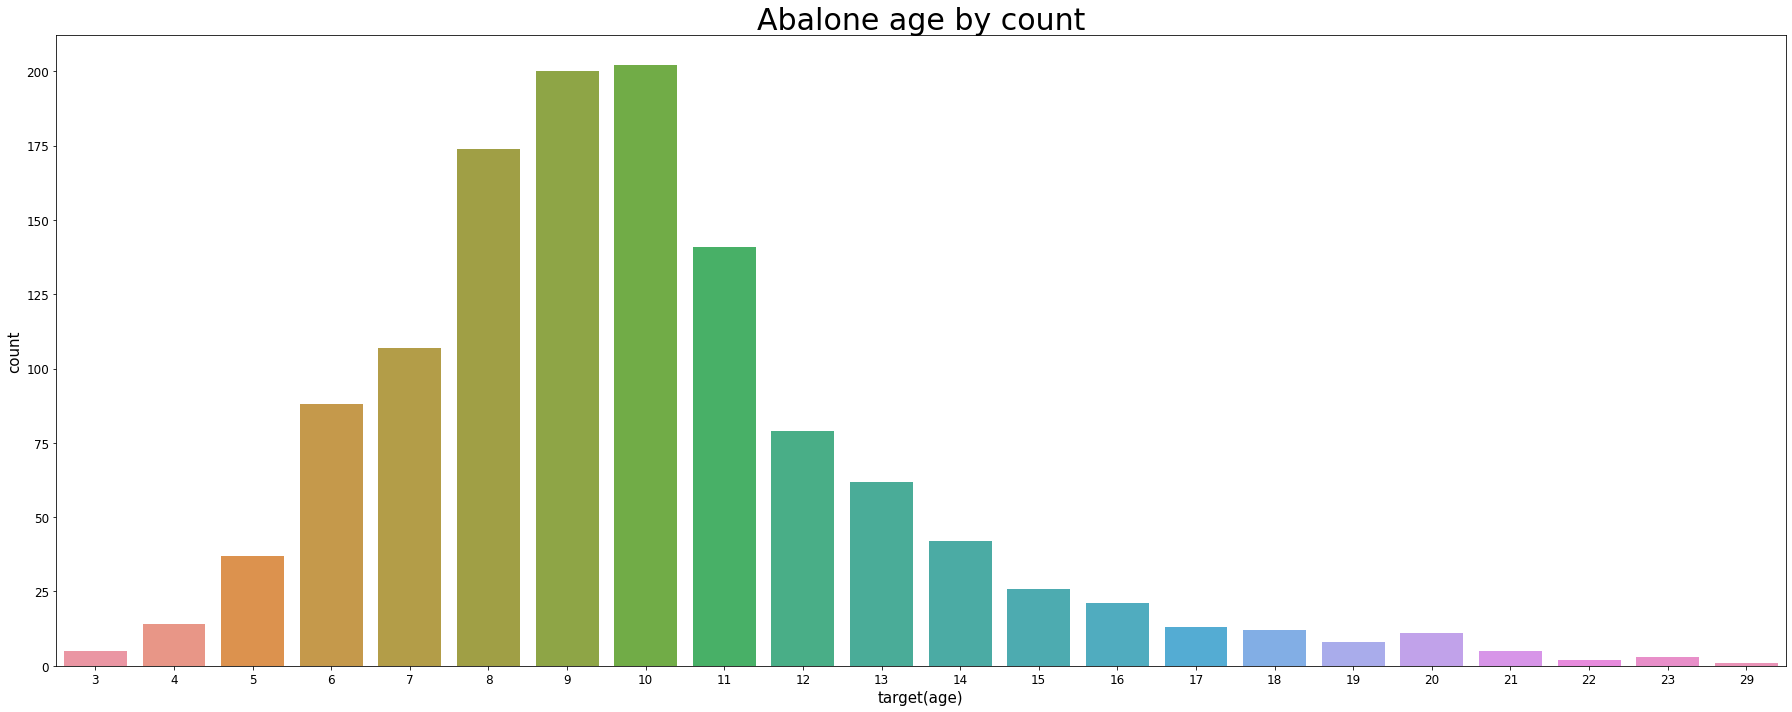

In [14]:
fig, ax = plt.subplots(1, figsize=(25,10))
sns.countplot('Target', data=train)
plt.title("Abalone age by count", fontsize=30)
plt.xlabel("target(age)", fontsize=15)
plt.ylabel("count", fontsize=15)
save_fig("Abalone age by count")
plt.show();

In [15]:
# 데이터 기초 통계 분석
# 카테고리형 데이터
# 'Gender' 시각화
train['Gender'].unique()

array(['M', 'I', 'F'], dtype=object)

In [16]:
train.groupby('Gender').count().iloc[:,0]

Gender
F    380
I    404
M    469
Name: Lenght, dtype: int64

그림 저장: Abalone gender by count


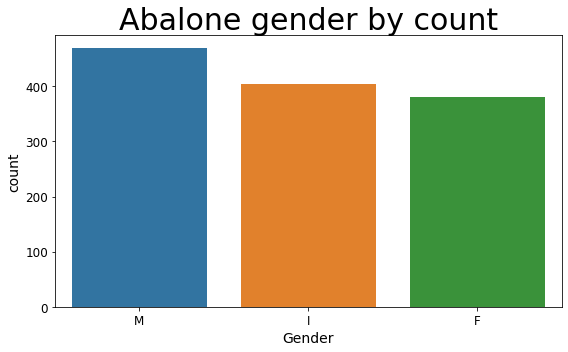

In [17]:
plt.figure(figsize=(8,5))
sns.countplot('Gender', data=train)
plt.title("Abalone gender by count", fontsize=30)
save_fig("Abalone gender by count")
plt.show();

그림 저장: Abalone age by gender


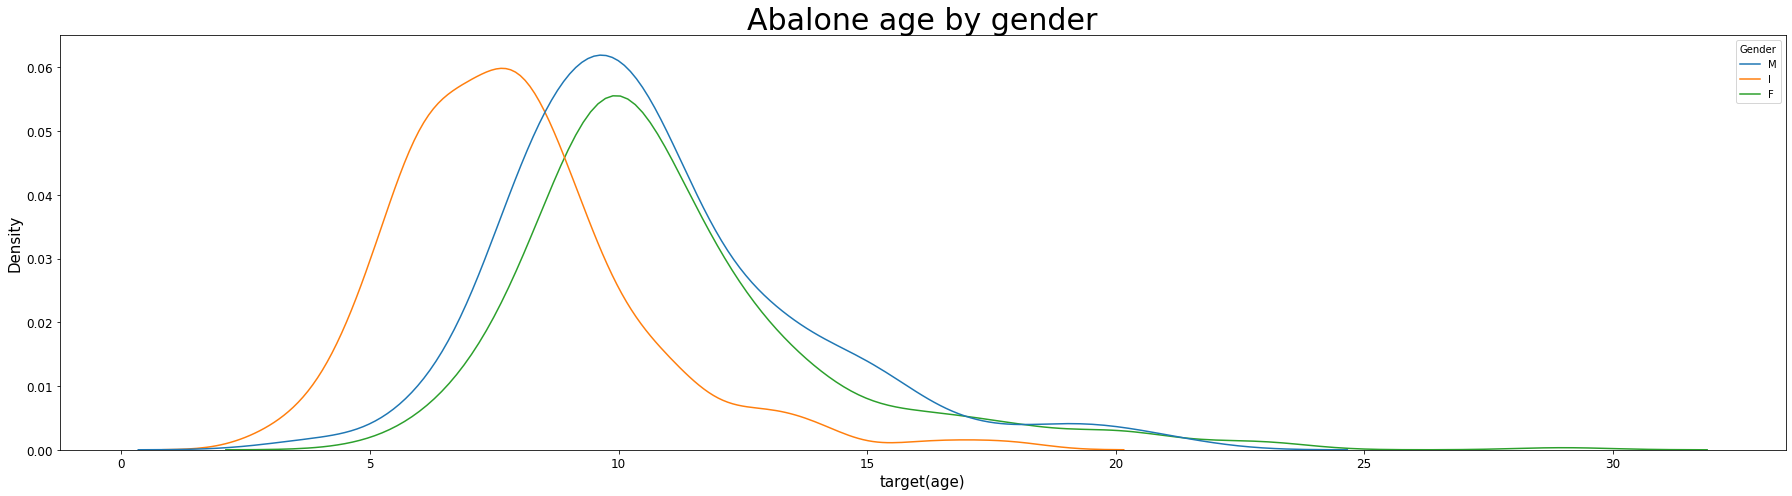

In [18]:
# 성별별로 나이의 분포
plt.figure(figsize=(25, 7))
sns.kdeplot('Target', hue='Gender', data=train)
plt.title('Abalone age by gender', fontsize=30)
plt.xlabel('target(age)', fontsize=15)
plt.ylabel('Density', fontsize=15)
save_fig("Abalone age by gender")
plt.show()

In [19]:
# 수치형 데이터 시각화
description = train.describe()
description

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,0.522869,0.406963,0.139545,0.831199,0.358818,0.181006,0.240077,9.912211
std,0.120231,0.099771,0.039033,0.500491,0.224612,0.111936,0.142574,3.214676
min,0.110000,0.090000,0.030000,0.008000,0.002500,0.002000,0.003000,3.000000
25%,0.445000,0.345000,0.115000,0.440500,0.182500,0.092500,0.130000,8.000000
50%,0.535000,0.420000,0.140000,0.777500,0.326000,0.168000,0.230000,10.000000
75%,0.615000,0.480000,0.165000,1.160000,0.505500,0.256500,0.330000,11.000000
max,0.780000,0.630000,0.250000,2.779500,1.488000,0.760000,1.005000,29.000000


그림 저장: Histogram of interesting features


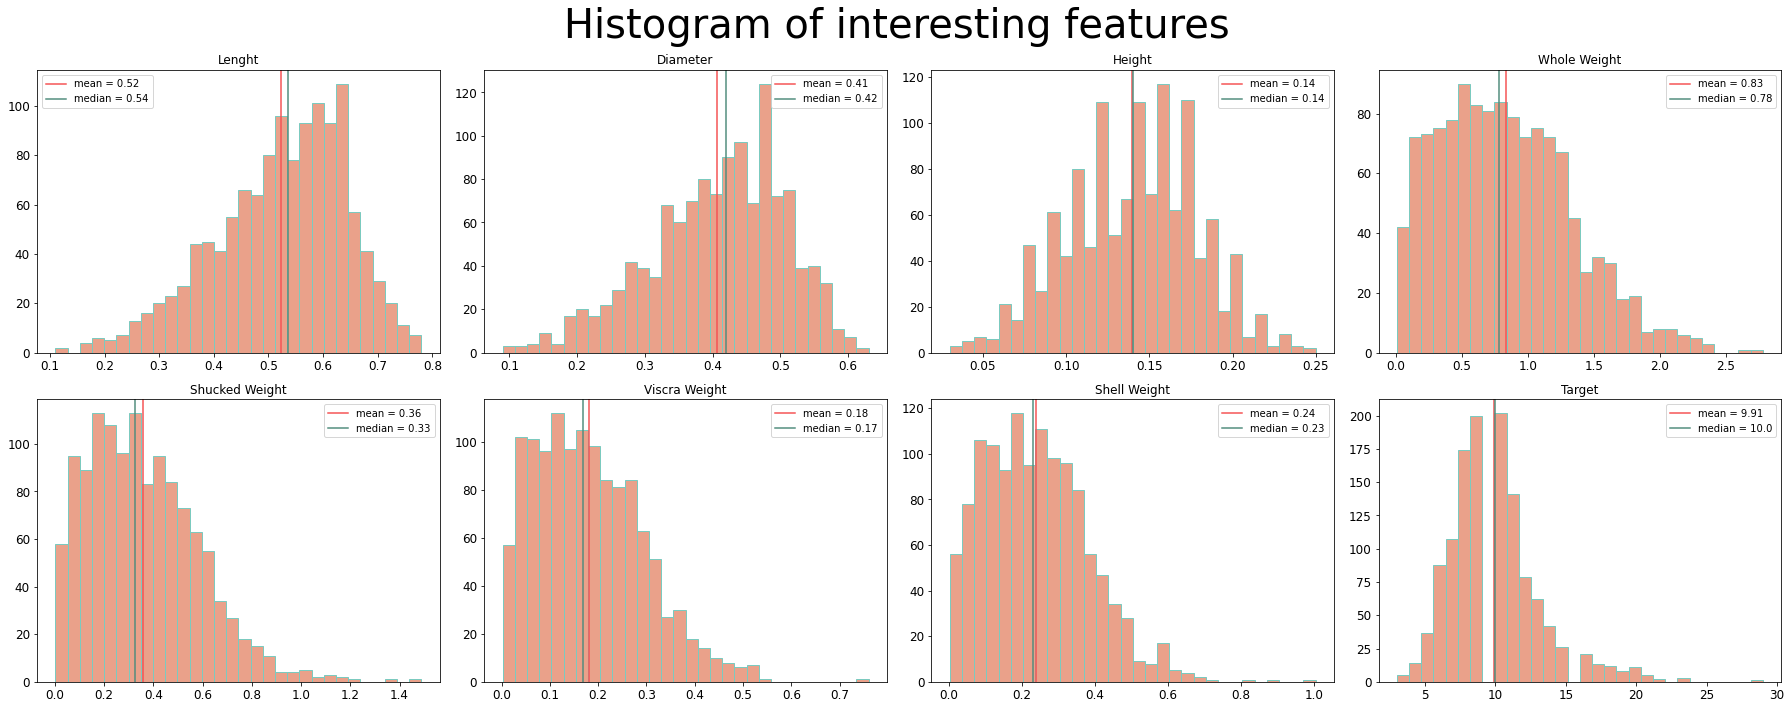

In [20]:
# 수치형 데이터 통계치 그래프
interest_coloumns = train.columns[1:]
# plt.style.use('fivethirtyeight')
fig, ax =plt.subplots(2, 4, figsize = (25, 10))
fig.suptitle('Histogram of interesting features', fontsize=40)
column_idx = 0
for i in range(2):
    for j in range(4):
        ax[i][j].hist(train[interest_coloumns[column_idx]], bins=30, color='#eaa18a', edgecolor='#7bcabf')
        ax[i][j].set_title(interest_coloumns[column_idx])
        ax[i][j].axvline(description[interest_coloumns[column_idx]]['mean'], c='#f55354', label = f"mean = {round(description[interest_coloumns[column_idx]]['mean'], 2)}")
        ax[i][j].axvline(description[interest_coloumns[column_idx]]['50%'], c='#518d7d', label = f"median = {round(description[interest_coloumns[column_idx]]['50%'], 2)}")
        ax[i][j].legend()
        column_idx += 1
save_fig("Histogram of interesting features")

In [21]:
def visualize(axx, yfield):
    sns.regplot(x='Target', y=yfield, data=train,  color='#eaa18a', line_kws=  {'color': '#f55354'} , ax = axx) # regplot을 이용하여 추세선과 산점도 그래프를 그려줍니다.
    axx.set_title(yfield)

그림 저장: Correlation between target and features


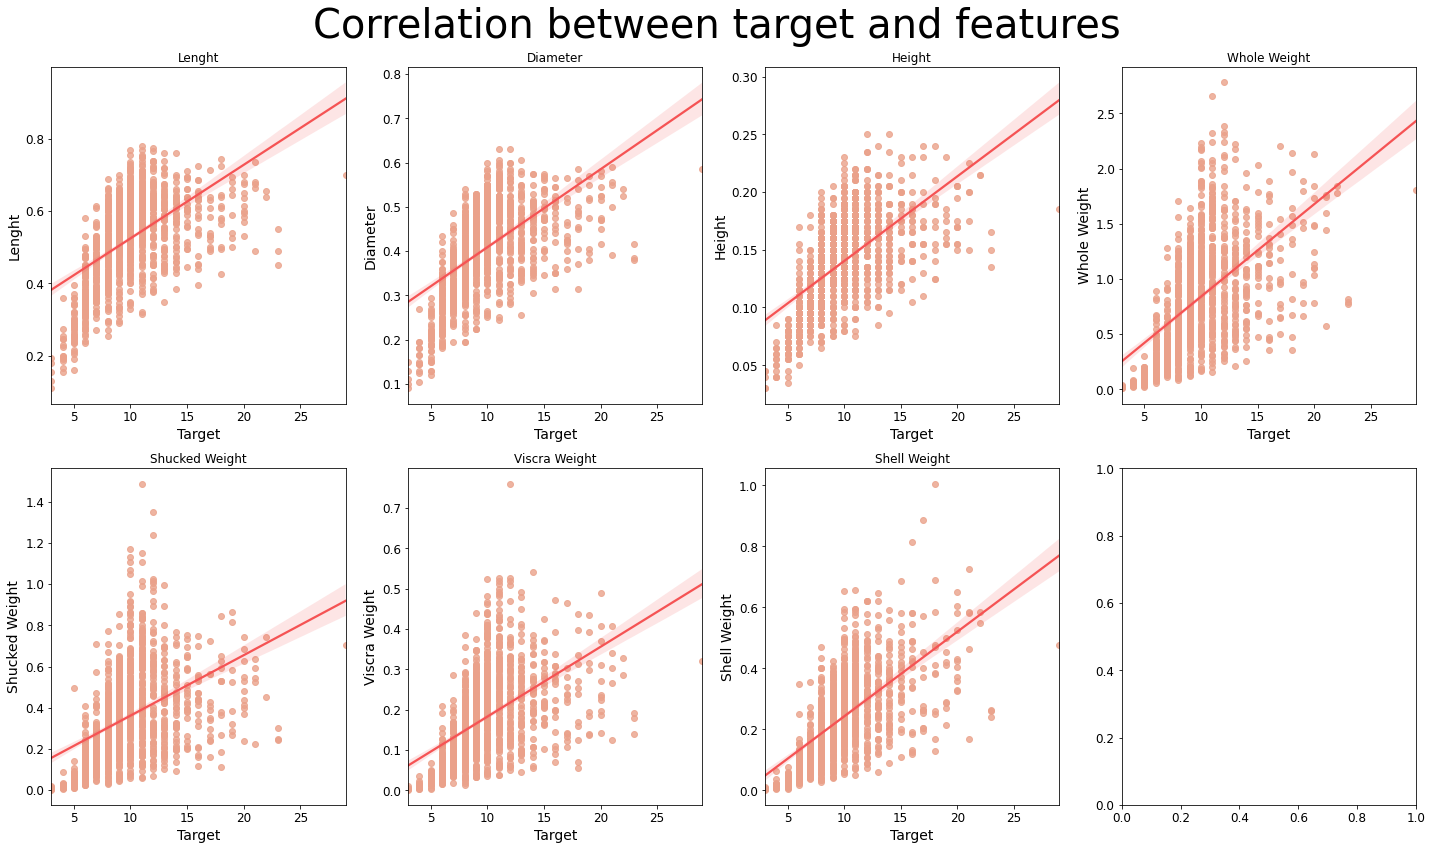

In [22]:
figure, ((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8)) = plt.subplots(nrows=2, ncols=4)
figure.set_size_inches(20,12)
figure.suptitle('Correlation between target and features', fontsize=40)

for i in range(len(train.columns[1:-1])):
    visualize(eval(f'ax{i+1}'), train.columns[i+1])
save_fig("Correlation between target and features")

In [23]:
# 수치형 데이터 상관관계 히트맵
train_corr = train.drop(columns=['Gender'], axis=1)
corr = train_corr.corr(method='pearson')

그림 저장: Correlation between features


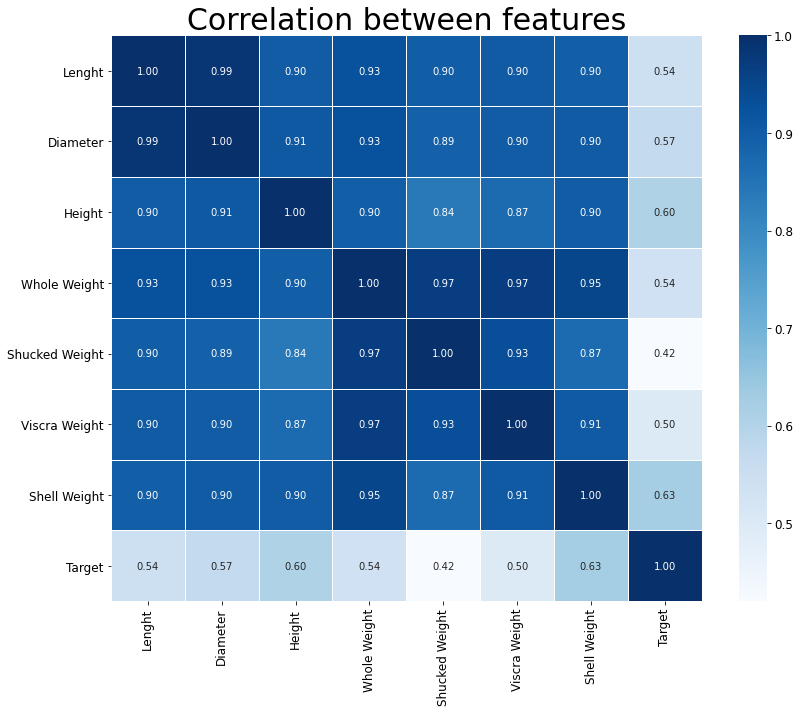

In [24]:
plt.figure(figsize=(12, 10))
sns.heatmap(data=corr, annot=True, fmt='.2f', linewidths=.5, cmap='Blues')
plt.title('Correlation between features', fontsize=30)
save_fig('Correlation between features')
plt.show()

In [25]:
# target과 피처들의 상관관계
unstacked = corr.unstack()
unstacked_df = pd.DataFrame(unstacked['Target'].sort_values(ascending=False), columns=['Target'])
unstacked_df.style.background_gradient(cmap='viridis')

,Target
Target,1.000000
Shell Weight,0.625819
Height,0.604654
Diameter,0.567933
Lenght,0.543789
Whole Weight,0.538404
Viscra Weight,0.497283
Shucked Weight,0.420126


## Modeling

In [26]:
le = LabelEncoder()
minmax = MinMaxScaler()

In [27]:
result = le.fit_transform(train['Gender'])
train_new = train.drop(['Gender'], 1)
train_new['Gender_encoded'] = result

In [28]:
result = le.transform(test['Gender'])
test_new = test.drop(['id','Gender'], 1)
test_new['Gender_encoded'] = result

In [29]:
X = train_new.drop(['Target'], axis=1)
y = train_new['Target']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

X_train = minmax.fit_transform(X_train)
X_valid = minmax.transform(X_valid)
X_test = minmax.transform(X_test)

In [30]:
test_new = minmax.transform(test_new)

In [32]:
# model 생성
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
mse_test

Epoch 1/20
22/22 [==============================] - 0s 12ms/step - loss: 100.4511 - val_loss: 71.4135
Epoch 2/20
22/22 [==============================] - 0s 999us/step - loss: 61.8037 - val_loss: 31.0934
Epoch 3/20
22/22 [==============================] - 0s 949us/step - loss: 25.9482 - val_loss: 11.6199
Epoch 4/20
22/22 [==============================] - 0s 881us/step - loss: 8.5926 - val_loss: 8.1378
Epoch 5/20
22/22 [==============================] - 0s 932us/step - loss: 7.9829 - val_loss: 7.8224
Epoch 6/20
22/22 [==============================] - 0s 945us/step - loss: 9.0825 - val_loss: 7.7728
Epoch 7/20
22/22 [==============================] - 0s 943us/step - loss: 8.0931 - val_loss: 7.7099
Epoch 8/20
22/22 [==============================] - 0s 938us/step - loss: 7.6270 - val_loss: 7.6762
Epoch 9/20
22/22 [==============================] - 0s 978us/step - loss: 6.9066 - val_loss: 7.6449
Epoch 10/20
22/22 [==============================] - 0s 999us/step - loss: 7.4841 - val_loss: 

6.361674785614014

In [34]:
y_pred = model.predict(test_new).flatten()

In [35]:
submission['Target'] = np.around(y_pred)
submission['Target'] = submission['Target'].astype('int')
submission.to_csv('data/submission.csv', index=False)

In [36]:
# model 생성
model2 = keras.models.Sequential([
    keras.layers.Dense(60, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model2.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
mse_test

Epoch 1/50
22/22 [==============================] - 0s 3ms/step - loss: 7.1962 - val_loss: 7.4029
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 7.1826 - val_loss: 7.3858
Epoch 3/50
22/22 [==============================] - 0s 999us/step - loss: 7.1717 - val_loss: 7.3722
Epoch 4/50
22/22 [==============================] - 0s 940us/step - loss: 7.1517 - val_loss: 7.3586
Epoch 5/50
22/22 [==============================] - 0s 912us/step - loss: 7.1284 - val_loss: 7.3557
Epoch 6/50
22/22 [==============================] - 0s 953us/step - loss: 7.1230 - val_loss: 7.3330
Epoch 7/50
22/22 [==============================] - 0s 906us/step - loss: 7.1143 - val_loss: 7.3217
Epoch 8/50
22/22 [==============================] - 0s 906us/step - loss: 7.0865 - val_loss: 7.3104
Epoch 9/50
22/22 [==============================] - 0s 1ms/step - loss: 7.0804 - val_loss: 7.3000
Epoch 10/50
22/22 [==============================] - 0s 954us/step - loss: 7.0643 - val_loss: 7.2896
Epoch

5.898545742034912

In [37]:
y_pred = model.predict(test_new).flatten()

In [38]:
submission['Target'] = np.around(y_pred)
submission['Target'] = submission['Target'].astype('int')
submission.to_csv('data/submission.csv', index=False)

In [ ]:
# 단위가 다르기 때문에 스케일링 진행 -> minmaxscaler
# 우선 모델링한 다음에 ols 진행
# 그 다음에 피처 엔지니어링 
# polynomial
# pca 

In [ ]:
# 다중공산성

In [46]:
train_new2 = train.drop(['Target'], 1)
train_new2 = pd.get_dummies(train_new2)

In [50]:
test_new2 = test.drop(['id'], 1)
test_new2 = pd.get_dummies(test_new2)

In [54]:
X = train_new2
y = train['Target']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

X_train = minmax.fit_transform(X_train)
X_valid = minmax.transform(X_valid)
X_test = minmax.transform(X_test)

In [59]:
test_new2 = minmax.transform(test_new2)

In [61]:
# model 생성
model = keras.models.Sequential([
    keras.layers.Dense(60, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
mse_test

Epoch 1/50
22/22 [==============================] - 0s 3ms/step - loss: 97.0172 - val_loss: 62.1274
Epoch 2/50
22/22 [==============================] - 0s 1ms/step - loss: 49.7976 - val_loss: 22.5617
Epoch 3/50
22/22 [==============================] - 0s 1ms/step - loss: 15.7695 - val_loss: 9.1573
Epoch 4/50
22/22 [==============================] - 0s 957us/step - loss: 7.4843 - val_loss: 7.6372
Epoch 5/50
22/22 [==============================] - 0s 960us/step - loss: 7.7751 - val_loss: 7.4877
Epoch 6/50
22/22 [==============================] - 0s 905us/step - loss: 7.6357 - val_loss: 7.4301
Epoch 7/50
22/22 [==============================] - 0s 1ms/step - loss: 8.9827 - val_loss: 7.4069
Epoch 8/50
22/22 [==============================] - 0s 1ms/step - loss: 5.7548 - val_loss: 7.3747
Epoch 9/50
22/22 [==============================] - 0s 1ms/step - loss: 7.2084 - val_loss: 7.3428
Epoch 10/50
22/22 [==============================] - 0s 983us/step - loss: 6.5191 - val_loss: 7.3191
Epoch 

5.867865085601807

In [63]:
y_pred = model.predict(test_new2).flatten()

In [64]:
submission['Target'] = np.around(y_pred)
submission['Target'] = submission['Target'].astype('int')
submission.to_csv('data/submission.csv', index=False)